In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from imgaug import augmenters as iaa
import torchvision.transforms as transforms
from PIL import Image
from imgaug import augmenters as iaa
import h5py

In [2]:
def delete_random_patch(arr):
    
    num_patches = np.random.randint(5,10)
    patch_size = np.random.randint(17,20)
    div = 96 // patch_size

    for _ in range(num_patches):
        i,j = np.random.randint(0,div+1)*patch_size,np.random.randint(0,div+1)*patch_size
        arr[i:i+patch_size, j:j+patch_size,:] = 0
    
    return arr


def new_background(label):
    
    new_image = np.copy(train_back[np.random.randint(0,train_back.shape[0])])
    greyscale_image = np.mean(label, axis=2)
    mask = greyscale_image > 0
    new_image[mask,:] = label[mask,:]

    
    return new_image


In [3]:
test_noisy = np.load("data/test_noisy_100.npy")
train_noisy = np.load("data/train_noisy.npy")
train_clean = np.load("data/train_clean.npy")
train_back= np.load("data/train_background_2.npy")


In [4]:


p_soft = 0.1
soft_transform = iaa.Sequential([
                # iaa.Sometimes(p_soft, iaa.Affine(scale=(1.0, 1.2))),
                iaa.Sometimes(0.5,iaa.Invert(0.25, per_channel=0.5)),
                iaa.Sometimes(0.5,iaa.Add((-50, 50), per_channel=0.5)),
                iaa.Sometimes(p_soft,iaa.Multiply((0.5, 1.5), per_channel=0.5)),
                iaa.Sometimes(p_soft,iaa.LinearContrast((0.5, 1.5), per_channel=0.5)),
                iaa.Sometimes(p_soft,iaa.Grayscale(alpha=(0.0, 1.0))),

                iaa.Sometimes(p_soft,iaa.OneOf([
                    iaa.GammaContrast((0.25, 5.0)),
                    iaa.GammaContrast((0.25, 5.0), per_channel=True),
                ])),
                iaa.Sometimes(p_soft, iaa.MultiplyAndAddToBrightness(mul=(0.3, 2), add=(-100, 100))),
                iaa.Sometimes(p_soft,iaa.AddToHueAndSaturation((-100, 100), per_channel=True)),
               
                
                ], random_order=True)


p_soft_fake = 0.25
soft_transform_fake = iaa.Sequential([
                iaa.Sometimes(p_soft_fake, iaa.Affine(scale=(1.0, 1.2))),
                iaa.Sometimes(0.6,iaa.Invert(0.25, per_channel=0.5)),
                iaa.Sometimes(0.6,iaa.Add((-50, 50), per_channel=0.5)),
                iaa.Sometimes(p_soft_fake,iaa.Multiply((0.5, 1.5), per_channel=0.5)),
                iaa.Sometimes(p_soft_fake,iaa.LinearContrast((0.5, 1.5), per_channel=0.5)),
                iaa.Sometimes(p_soft_fake,iaa.Grayscale(alpha=(0.0, 1.0))),

                iaa.Sometimes(p_soft_fake,iaa.OneOf([
                    iaa.GammaContrast((0.25, 5.0)),
                    iaa.GammaContrast((0.25, 5.0), per_channel=True),
                ])),
                iaa.Sometimes(p_soft_fake, iaa.MultiplyAndAddToBrightness(mul=(0.3, 2), add=(-100, 100))),
                iaa.Sometimes(p_soft_fake,iaa.AddToHueAndSaturation((-100, 100), per_channel=True)),
               
                
                ], random_order=True)





def aug_noisy(idx):

    x = np.copy(train_noisy[idx].astype(np.uint8))
    
    y = np.copy(train_clean[idx].astype(np.uint8))

    

    if np.random.rand() < 0.25:
        x = delete_random_patch(x)

    x = soft_transform.augment_image(x)

    return x,y


def aug_fake(idx):

    y = np.copy(train_clean[idx].astype(np.uint8))
    
    x = np.copy(new_background(y))
    
    if np.random.rand() < 0.75:
        x = delete_random_patch(x)
    
    x = soft_transform_fake.augment_image(x)

    
    return x,y

In [5]:
n = 1_000_000
# n = 10_000

idx1 = 0
for i in range(int(n/10_000)):
    for j in range(10000):

        idx2 = idx1+1

        sample_1 = np.zeros((2,96,96,3), dtype=np.uint8)
        sample_2 = np.zeros((2,96,96,3), dtype=np.uint8)


        sample_1[0], sample_1[1] = aug_noisy(j)
        sample_2[0], sample_2[1] = aug_fake(j)

        np.save(f"/home/daniel/dataset/sample_{idx1}.npy", sample_1)
        np.save(f"/home/daniel/dataset/sample_{idx2}.npy", sample_2)


        idx1 += 2
    print(f"{i+1} / {int(n/10_000)}")
        



1 / 100
2 / 100
3 / 100
4 / 100
5 / 100
6 / 100
7 / 100
8 / 100
9 / 100
10 / 100
11 / 100
12 / 100
13 / 100
14 / 100
15 / 100
16 / 100
17 / 100
18 / 100
19 / 100
20 / 100
21 / 100
22 / 100
23 / 100
24 / 100
25 / 100
26 / 100
27 / 100
28 / 100
29 / 100
30 / 100
31 / 100
32 / 100
33 / 100
34 / 100
35 / 100
36 / 100
37 / 100
38 / 100
39 / 100
40 / 100
41 / 100
42 / 100
43 / 100
44 / 100
45 / 100
46 / 100
47 / 100
48 / 100
49 / 100
50 / 100
51 / 100
52 / 100
53 / 100
54 / 100
55 / 100
56 / 100
57 / 100
58 / 100
59 / 100
60 / 100
61 / 100
62 / 100
63 / 100
64 / 100
65 / 100
66 / 100
67 / 100
68 / 100
69 / 100
70 / 100
71 / 100
72 / 100
73 / 100
74 / 100
75 / 100
76 / 100
77 / 100
78 / 100
79 / 100
80 / 100
81 / 100
82 / 100
83 / 100
84 / 100
85 / 100
86 / 100
87 / 100
88 / 100
89 / 100
90 / 100
91 / 100
92 / 100
93 / 100
94 / 100
95 / 100
96 / 100
97 / 100
98 / 100
99 / 100
100 / 100


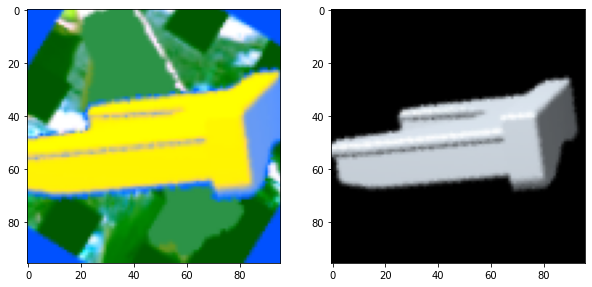

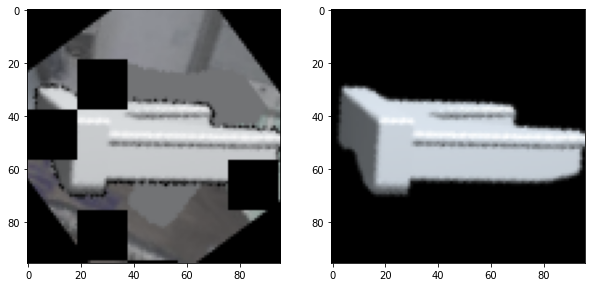

In [ ]:

i = 1
j = i + 20_000

fig, ax = plt.subplots(1,2, figsize=(10,10))
ax[0].imshow(np.load(f"./dataset/noisy_{i}.npy"))
ax[1].imshow(np.load(f"./dataset/clean_{i}.npy"))

plt.show()
fig, ax = plt.subplots(1,2, figsize=(10,10))
ax[0].imshow(np.load(f"./dataset2/noisy_{j}.npy"))
ax[1].imshow(np.load(f"./dataset2/clean_{j}.npy"))

plt.show()

1300931


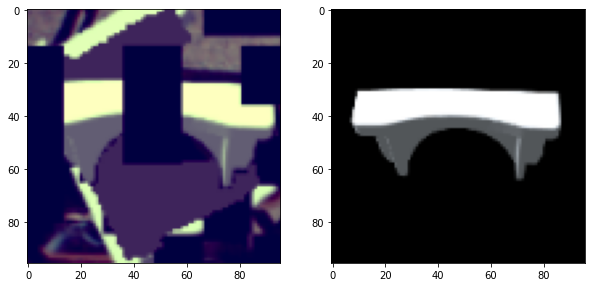

1351204


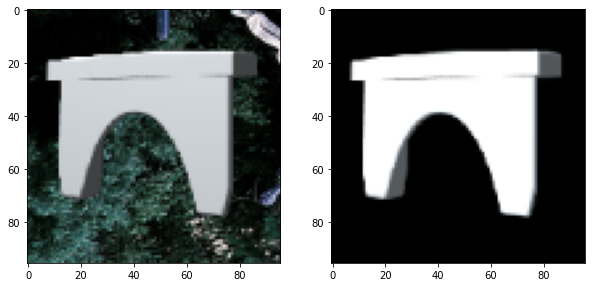

297797


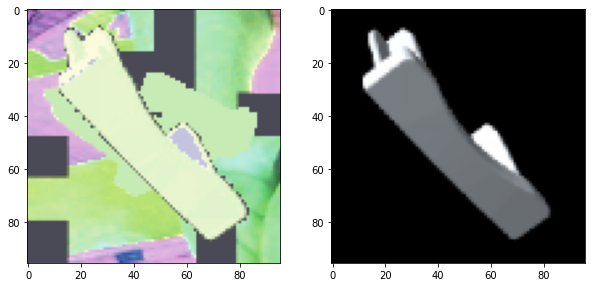

1704940


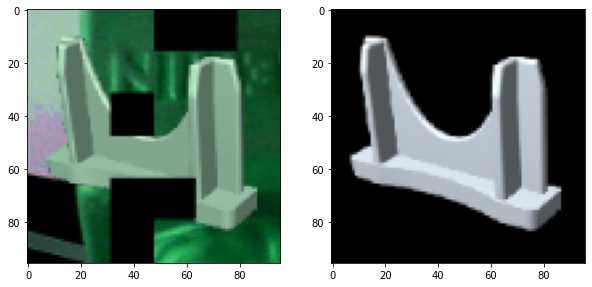

426615


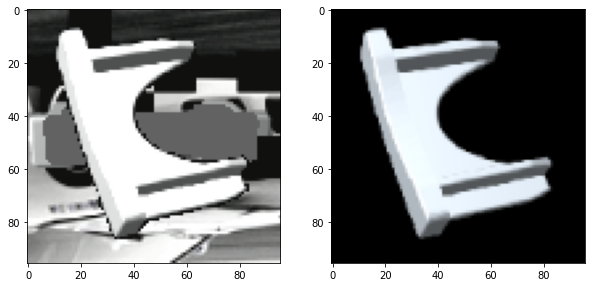

In [22]:
n = 5
ints = np.random.randint(0, high=2_000_000, size=n)
for i in range(n):
    fig, ax = plt.subplots(1,2, figsize=(10,10))
    ax[0].imshow(np.load(f"./dataset/noisy_{ints[i]}.npy"))
    ax[1].imshow(np.load(f"./dataset/clean_{ints[i]}.npy"))
    print(ints[i])
    plt.show()

plt.show()

(96, 96, 3)
70


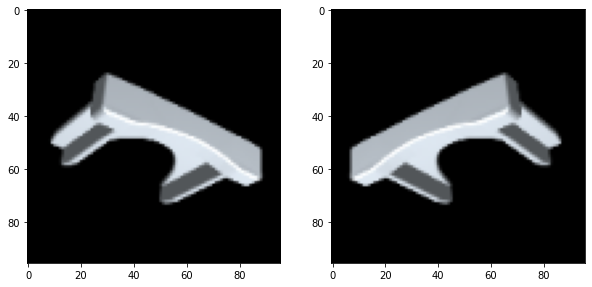

(96, 96, 3)
74


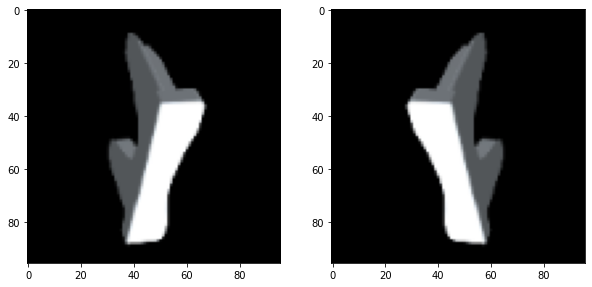

(96, 96, 3)
62


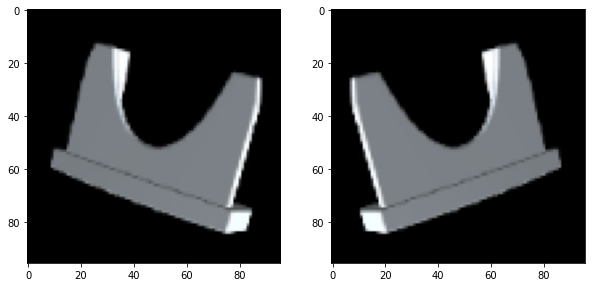

(96, 96, 3)
78


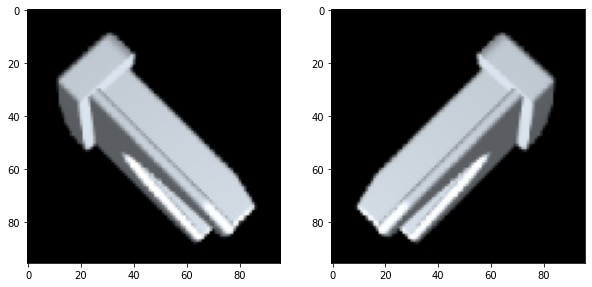

(96, 96, 3)
20


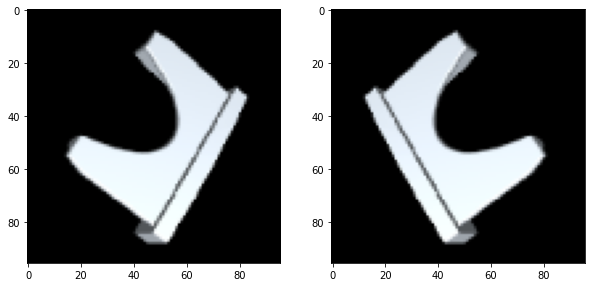

In [23]:
n = 5

ints = np.random.randint(0, high=test_noisy.shape[0], size=n)
for i in range(n):
    fig, ax = plt.subplots(1,2, figsize=(10,10))
    ax[0].imshow(train_clean[ints[i]])
    ax[1].imshow(fuck.augment_image(train_clean[ints[i]]))
    print(train_clean[ints[i]].shape)
    print(ints[i])
    plt.show()

plt.show()

In [243]:
train_noisy[95,:,:,2]

array([[247, 245, 212, ..., 123, 139, 227],
       [241, 244, 226, ..., 135, 147, 190],
       [246, 239, 222, ..., 143, 136, 176],
       ...,
       [121, 126, 160, ..., 255, 255, 255],
       [117, 123, 127, ..., 254, 255, 255],
       [202, 206, 213, ..., 252, 254, 254]], dtype=uint8)

In [11]:
arr = np.load("dataset/train_noisy.npy")

for i in range(len(arr)):
    np.save(f"data2/noisy_{i}.npy", arr[i])


FileNotFoundError: [Errno 2] No such file or directory: 'dataset/train_noisy.npy'

In [12]:
import h5py
